# CESM2-LE Initial Condition Memory:  Zonal-mean SST
 - Use Intake to access CESM2LE data on glade
 - Compute zonal mean annual SST from POP monthly output for all members from 1850-2100
 - Plot Hovmuller of micro-to-total variance vs. time
 - Request at least 50GB on Casper login to run this notebook

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
intake.__version__

'0.6.3'

## Create Dask Cluster

In [19]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(5) 

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41385 instead
  warnings.warn(


In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43382 instead
  warnings.warn(


In [3]:
cluster

In [3]:
pp_datafile = '/glade/scratch/yeager/cesm2_le/CESM2LE_zmSST.nc'
if (exists(pp_datafile)):
        print(pp_datafile+' already exists.\n\n')
else:
    print(pp_datafile+' does NOT exist.\n\n')

/glade/scratch/yeager/cesm2_le/CESM2LE_zmSST.nc already exists.




If CESM2LE post-processed zonal mean SST file already exists, you don't need to do Section 1 (~30 minutes). Go to [Section 2](#section2). 

# Section 1

## Data Intake

In [4]:
# Point to the catalog file
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
col = intake.open_esm_datastore(catalog_file)
oceandata = col.search(component='ocn', 
                       variable=['TEMP'], 
                       frequency='month_1', 
                       experiment=['historical','ssp370'])

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
# This may not be necessary in newer versions of intake-esm:
oceandata.df = oceandata.df.sort_values(by=['time_range'])

In [16]:
oceandata.search(experiment='historical',forcing_variant='cmip6').df

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,TEMP,1850-01,1859-12,185001-185912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1281.009,r9i1281p1f1,TEMP,1850-01,1859-12,185001-185912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1281.009,1281,CESM2_historical_r9i1281p1f1
2,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1281.004,r4i1281p1f1,TEMP,1850-01,1859-12,185001-185912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1281.004,1281,CESM2_historical_r4i1281p1f1
3,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1251.005,r5i1251p1f1,TEMP,1850-01,1859-12,185001-185912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1251.005,1251,CESM2_historical_r5i1251p1f1
4,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.001,r1i1231p1f1,TEMP,1850-01,1859-12,185001-185912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.001,1231,CESM2_historical_r1i1231p1f1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1181.010,r1i1231p1f1,TEMP,2010-01,2014-12,201001-201412,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.001,1231,CESM2_historical_r1i1231p1f1
846,ocn,pop.h,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r1i1001p1f1,TEMP,2065-01,2074-12,206501-207412,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
847,ocn,pop.h,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r1i1001p1f1,TEMP,2075-01,2084-12,207501-208412,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
848,ocn,pop.h,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r1i1001p1f1,TEMP,2085-01,2094-12,208501-209412,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1


In [17]:
oceandata.search(experiment='ssp370',forcing_variant='cmip6').df

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ocn,pop.h,b.e21.BHISTsmbb.f09_g17.LE2-1301.020,r1i1001p1f1,TEMP,1980-01,1989-12,198001-198912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,ocn,pop.h,b.e21.BHISTsmbb.f09_g17.LE2-1301.020,r1i1001p1f1,TEMP,1990-01,1999-12,199001-199912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,ocn,pop.h,b.e21.BHISTsmbb.f09_g17.LE2-1301.020,r1i1001p1f1,TEMP,2000-01,2009-12,200001-200912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,ocn,pop.h,b.e21.BHISTsmbb.f09_g17.LE2-1301.020,r1i1001p1f1,TEMP,2010-01,2014-12,201001-201412,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,ocn,pop.h,b.e21.BSSP370cmip6.f09_g17.LE2-1251.010,r10i1251p1f1,TEMP,2015-01,2024-12,201501-202412,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1251.010,1251,CESM2_ssp370_r10i1251p1f1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,ocn,pop.h,b.e21.BSSP370cmip6.f09_g17.LE2-1301.006,r7i1301p1f1,TEMP,2095-01,2100-12,209501-210012,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1301.007,1301,CESM2_ssp370_r7i1301p1f1
446,ocn,pop.h,b.e21.BSSP370cmip6.f09_g17.LE2-1301.007,r8i1301p1f1,TEMP,2095-01,2100-12,209501-210012,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1301.008,1301,CESM2_ssp370_r8i1301p1f1
447,ocn,pop.h,b.e21.BSSP370cmip6.f09_g17.LE2-1301.008,r9i1301p1f1,TEMP,2095-01,2100-12,209501-210012,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1301.009,1301,CESM2_ssp370_r9i1301p1f1
448,ocn,pop.h,b.e21.BSSP370cmip6.f09_g17.LE2-1301.009,r10i1301p1f1,TEMP,2095-01,2100-12,209501-210012,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,ssp370,cmip6,1301.010,1301,CESM2_ssp370_r10i1301p1f1


In [8]:
## Use preprocessor to return annual mean SST
def preproc(ds):
    ds = calc.center_time(ds.isel(z_t=0))
    ds_ann = ds.groupby('time.year').mean().rename({'year':'time'})
    ds_ann.TEMP.attrs = ds.TEMP.attrs
    return ds_ann

In [9]:
%%time
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Create a dataset dictionary from the subsampled catalog
cbc_args = {'data_vars':'minimal'}
dsets = oceandata.to_dataset_dict(
    #xarray_combine_by_coords_kwargs=cbc_args,
    preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 21s, sys: 2.49 s, total: 1min 23s
Wall time: 2min 5s


In [10]:
dsets.keys()

dict_keys(['ocn.historical.pop.h.smbb.TEMP', 'ocn.ssp370.pop.h.cmip6.TEMP', 'ocn.historical.pop.h.cmip6.TEMP', 'ocn.ssp370.pop.h.smbb.TEMP'])

In [14]:
dsets['ocn.ssp370.pop.h.cmip6.TEMP'].time

<xarray.DataArray 'time' (time: 121)>
array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039,
       2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075,
       2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099,
       2100])
Coordinates:
  * time     (time) int64 1980 1981 1982 1983 1984 ... 2096 2097 2098 2099 2100
    z_t      float32 500.0

## Data Processing

#### Prepare for Zonal Mean computation:

In [9]:
## Define target lat_aux grid:
lat_aux = xr.DataArray(np.linspace(-90,90,181),dims='lat',attrs={'units':'degrees_north','long_name':'latitude boundaries of zonal mean'})

In [10]:
## Define target region mask
grid_ds = pop_tools.get_grid('POP_gx1v7')
rmask = grid_ds.REGION_MASK
rmask = xr.where((rmask==1) & ((grid_ds['nlon']>=54) & (grid_ds['nlon']<=293)),2,rmask)
rmask = xr.where(rmask==3,2,rmask)
rmask = xr.where(rmask==4,2,rmask)
rmask = xr.where((rmask>=6) & (rmask<=11),1,rmask)
rmask = rmask.where(rmask>0)
rmaskdict = {0:'Global',1:'Atlantic+Arctic',2:'Indo-Pacific'}

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


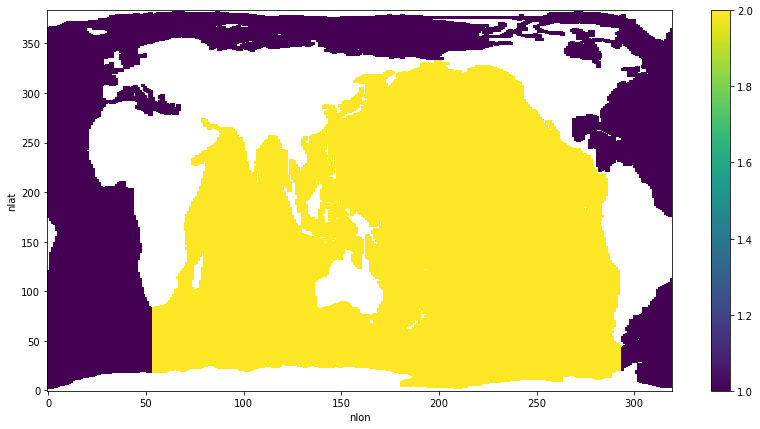

In [11]:
rmask.plot(aspect=2,size=7)

#### Compute Annual Zonal-mean SST from monthly TEMP:

In [12]:
%%time
ds = dsets['ocn.historical.pop.h.cmip6.TEMP']
cmip6hist_zm = calc.regional_zonal_mean(ds.TEMP,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').load()

CPU times: user 5min 4s, sys: 6.05 s, total: 5min 10s
Wall time: 7min 43s


In [13]:
%%time
ds = dsets['ocn.historical.pop.h.smbb.TEMP']
smbbhist_zm = calc.regional_zonal_mean(ds.TEMP,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').load()

CPU times: user 4min 3s, sys: 3.84 s, total: 4min 7s
Wall time: 6min 28s


In [14]:
%%time
ds = dsets['ocn.ssp370.pop.h.cmip6.TEMP']
cmip6ssp_zm = calc.regional_zonal_mean(ds.TEMP,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').load()

CPU times: user 2min 41s, sys: 3.06 s, total: 2min 44s
Wall time: 4min 21s


In [17]:
%%time
ds = dsets['ocn.ssp370.pop.h.smbb.TEMP']
smbbssp_zm = calc.regional_zonal_mean(ds.TEMP,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').load()

CPU times: user 1min 51s, sys: 2.08 s, total: 1min 53s
Wall time: 3min 26s


In [16]:
cmip6hist_zm.time

<xarray.DataArray 'time' (time: 201)>
array([1850, 1851, 1852, ..., 2098, 2099, 2100])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100

In [19]:
cmip6ssp_zm.time

<xarray.DataArray 'time' (time: 121)>
array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039,
       2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075,
       2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099,
       2100])
Coordinates:
  * time     (time) int64 1980 1981 1982 1983 1984 ... 2096 2097 2098 2099 2100

In [18]:
## Create final Dataset:
work1 = xr.concat([cmip6hist_zm,cmip6ssp_zm],dim='time')
work2 = xr.concat([smbbhist_zm,smbbssp_zm],dim='time')
cesm2le_zm = xr.concat([work1,work2],dim='member_id')
memid = cesm2le_zm.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':cesm2le_zm.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':cesm2le_zm.member_id})

ds = cesm2le_zm.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

ValueError: cannot reindex or align along dimension 'time' because the index has duplicate values

In [20]:
work1.time

<xarray.DataArray 'time' (time: 322)>
array([1850, 1851, 1852, ..., 2098, 2099, 2100])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100

In [22]:
work2.time

<xarray.DataArray 'time' (time: 251)>
array([1850, 1851, 1852, ..., 2098, 2099, 2100])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100

In [20]:
ds

<xarray.Dataset>
Dimensions:    (member_id: 100, time: 251, TLAT_bin: 180, region: 3)
Coordinates:
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1171p1f2'
  * time       (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * TLAT_bin   (TLAT_bin) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * region     (region) <U15 'Global' 'Atlantic+Arctic' 'Indo-Pacific'
Data variables:
    TEMP       (region, member_id, time, TLAT_bin) float64 nan nan ... nan nan
    inityear   (member_id) <U4 '1181' '1231' '1251' ... '1131' '1151' '1171'
    memnum     (member_id) <U3 '010' '010' '010' '010' ... '007' '008' '009'

In [21]:
## Save to netcdf:
ds.to_netcdf(pp_datafile)

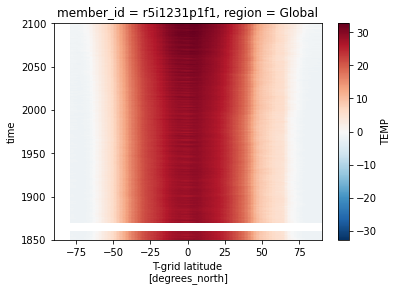

In [23]:
ds.TEMP.isel(member_id=26,region=0).plot();

<a id='section2'></a>

# Section 2

If you skipped Section 1, read in ds for analysis and plotting:

In [4]:
print('opening '+pp_datafile)
ds = xr.open_dataset(pp_datafile)

opening /glade/scratch/yeager/cesm2_le/CESM2LE_zmSST.nc


In [5]:
ds

<xarray.Dataset>
Dimensions:    (member_id: 100, time: 251, TLAT_bin: 180, region: 3)
Coordinates:
  * member_id  (member_id) object 'r10i1181p1f1' ... 'r9i1171p1f2'
  * time       (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * TLAT_bin   (TLAT_bin) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * region     (region) object 'Global' 'Atlantic+Arctic' 'Indo-Pacific'
Data variables:
    TEMP       (region, member_id, time, TLAT_bin) float64 ...
    inityear   (member_id) object ...
    memnum     (member_id) object ...

In [6]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Start Year : Members
1091 : 001
1021 : 001
1111 : 001
1151 : 001
1181 : 001
1001 : 001
1251 : 020
1121 : 001
1191 : 001
1301 : 020
1141 : 001
1231 : 020
1281 : 020
1101 : 001
1061 : 001
1071 : 001
1161 : 001
1131 : 001
1051 : 001
1171 : 001
1011 : 001
1081 : 001
1031 : 001
1041 : 001


Apply running-mean filter:

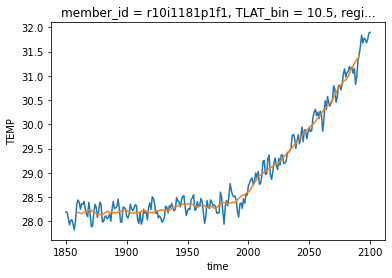

In [32]:
#ds['TEMP'] = lpf_anndata(ds.TEMP.transpose('time','region','member_id','TLAT_bin'),period=20)
ds.TEMP.isel(region=0,member_id=0,TLAT_bin=100).plot()
ds.TEMP.isel(region=0,member_id=0,TLAT_bin=100).rolling(time=20, center=True).mean().plot()

In [65]:
ds['TEMP'] = ds.TEMP.rolling(time=20, center=True).mean()

Apply low-pass filter:

In [7]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [8]:
temp_raw = ds['TEMP']
ds['TEMP'] = lpf_anndata(ds.TEMP.transpose('time','region','member_id','TLAT_bin'),period=20)

cutoff=  20.0  years


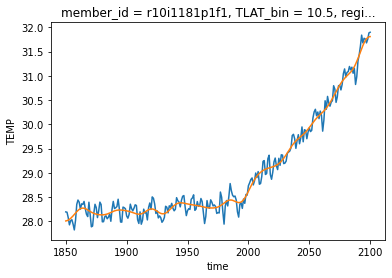

In [9]:
temp_raw.isel(region=0,member_id=0,TLAT_bin=100).plot()
ds.TEMP.isel(region=0,member_id=0,TLAT_bin=100).plot()

## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} + \sigma^{2}_{X,Cov(atm,ocn)}
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m-1}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p-1}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

For denominator, keep only the 4 20-member micro ensemble members (80 members total):

In [10]:
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_allmem = ds.TEMP.isel(member_id=memind[0])
sig2_tot = da_allmem.var(dim='member_id')
allmean = da_allmem.mean(dim='member_id')

In [11]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
covarlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    da_oneinit = ds.TEMP.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    #covar = (2*(da_oneinit - mean)*(mean-allmean))
    varlist.append(var)
    meanlist.append(mean)
    covarlist.append(covar)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_ocn_p.mean('p'))**2
#sig2_covar = xr.concat(covarlist,dim='p').mean('p').mean('member_id')
# Compute Chi
chi_atm = (sig2_atm/sig2_tot).rename("Chi")
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi")
chi_ocn_p = (sig2_ocn_p/sig2_tot).rename("Chi")
#chi_covar = (sig2_covar/sig2_tot).rename("Chi")

NameError: name 'covar' is not defined

In [60]:
sig2 = xr.concat([sig2_tot,sig2_atm,sig2_ocn,sig2_covar],dim=xr.DataArray(['sig2_tot','sig2_atm','sig2_ocn','sig2_covar'],dims='term',name='term'))

In [61]:
sig2.to_netcdf('/glade/scratch/yeager/cesm2_le/CESM2LE_zmSST_sig2terms.nc')

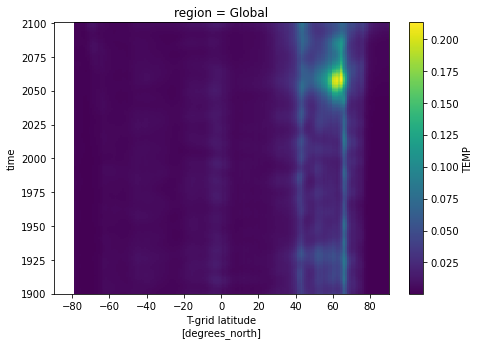

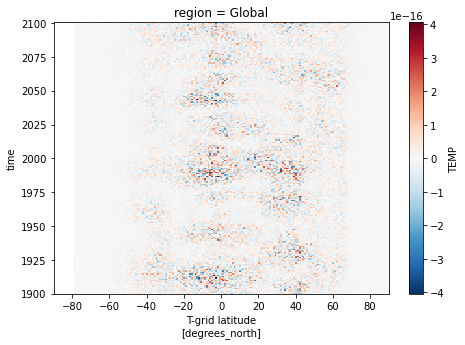

In [101]:
# Test for closure of variance budget:
#sig2_resid = sig2_tot - (sig2_atm+sig2_ocn+sig2_covar)
sig2_tot.isel(region=0).sel(time=slice(1900,2100)).plot(size=5)
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2_resid.isel(region=0).sel(time=slice(1900,2100)).plot(size=5)
#sig2_covar.isel(region=0).plot(size=5)

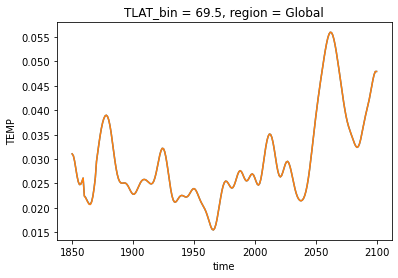

In [99]:
sig2_tot.isel(region=0).isel(TLAT_bin=159).plot()
(sig2_atm+sig2_ocn).isel(region=0).isel(TLAT_bin=159).plot()

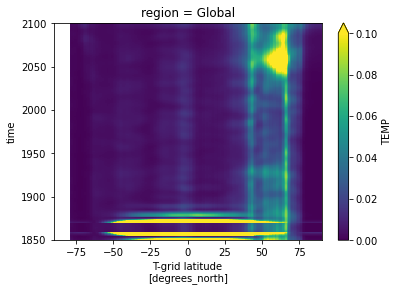

In [59]:
sig2_tot.isel(region=0).plot(vmin=0,vmax=0.1)

In [50]:
sig2_tot.isel(region=0).sel(TLAT_bin=60,method='nearest')

<xarray.DataArray 'TEMP' (time: 251)>
array([0.08840004, 0.08624436, 0.08054124, 0.07314683, 0.06687981,
       0.06508944, 0.07103985, 0.08718   , 0.11442686, 0.15163746,
       0.05770071, 0.05730505, 0.05696825, 0.05660071, 0.0561437 ,
       0.05555821, 0.05481547, 0.05389595, 0.05279823, 0.05155316,
       0.13397272, 0.09918221, 0.07367138, 0.05749986, 0.04925206,
       0.04672506, 0.04759988, 0.04993219, 0.05239506, 0.0542933 ,
       0.05542387, 0.05587301, 0.05582746, 0.05544693, 0.05481258,
       0.05393918, 0.05282229, 0.05148803, 0.05001944, 0.04854832,
       0.04721739, 0.04613004, 0.04530892, 0.04468033, 0.04409099,
       0.04335236, 0.04229868, 0.04084156, 0.03900529, 0.03693265,
       0.03485903, 0.03306147, 0.03179627, 0.03124234, 0.03146557,
       0.03241258, 0.03393282, 0.0358192 , 0.03785298, 0.03983979,
       0.04162931, 0.04311861, 0.04424554, 0.04498042, 0.0453226 ,
       0.04530399, 0.04499667, 0.04451843, 0.04402874, 0.04371018,
       0.04373502, 0.04422438, 0.04521178, 0.04662421, 0.0482886 ,
       0.04996393, 0.05139083, 0.05234543, 0.05268293, 0.05235954,
       0.0514277 , 0.05000805, 0.04824897, 0.04628737, 0.04422296,
       0.04211141, 0.03997527, 0.03782549, 0.03568418, 0.03359985,
       0.03164903, 0.02992277, 0.02850213, 0.02743113, 0.02669814,
       0.02623366, 0.02592648, 0.02565338, 0.02531203, 0.02484679,
...
       0.02296302, 0.02343929, 0.02351635, 0.02323947, 0.02271651,
       0.02209636, 0.02154099, 0.0211956 , 0.02116221, 0.02148177,
       0.02212942, 0.02302485, 0.02405618, 0.02511127, 0.0261076 ,
       0.02701146, 0.02784057, 0.02865038, 0.02951   , 0.03047684,
       0.03157848, 0.03280662, 0.03412366, 0.03547883, 0.03682857,
       0.03815543, 0.03948085, 0.0408685 , 0.04241752, 0.04424693,
       0.04647499, 0.04919818, 0.05247492, 0.05631842, 0.0607009 ,
       0.06556825, 0.07086022, 0.07652981, 0.08255622, 0.08894953,
       0.09574877, 0.10301592, 0.11082584, 0.11924929, 0.12832501,
       0.13802089, 0.14819147, 0.15854593, 0.16864258, 0.17791997,
       0.18576306, 0.19159068, 0.19494335, 0.19555096, 0.19336763,
       0.18857109, 0.18153217, 0.17276371, 0.1628581 , 0.15242069,
       0.14200617, 0.13206491, 0.12290705, 0.11469003, 0.10743258,
       0.1010529 , 0.09542367, 0.09043132, 0.08602435, 0.08223629,
       0.07917508, 0.07698073, 0.07576485, 0.07555257, 0.07624725,
       0.07762891, 0.07938454, 0.08115704, 0.0825954 , 0.08339324,
       0.08331189, 0.08219341, 0.07997252, 0.07669235, 0.07252113,
       0.06775783, 0.06281274, 0.05815432, 0.05422625, 0.05135258,
       0.04965886, 0.04903758, 0.0491755 , 0.04964104, 0.05000785,
       0.04997455])
Coordinates:
  * time      (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
    TLAT_bin  float64 60.5
    region    <U6 'Global'

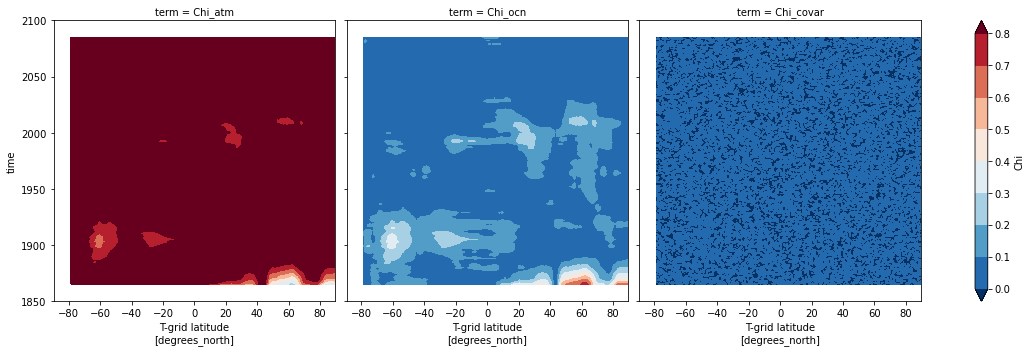

In [18]:
# Quick plot of Chi
chi = xr.concat([chi_atm,chi_ocn,chi_covar],dim=xr.DataArray(['Chi_atm','Chi_ocn','Chi_covar'],dims='term',name='term'))
levs = np.arange(0,9)*0.1
chi.isel(region=0).plot.contourf(col='term',size=5,levels=levs)

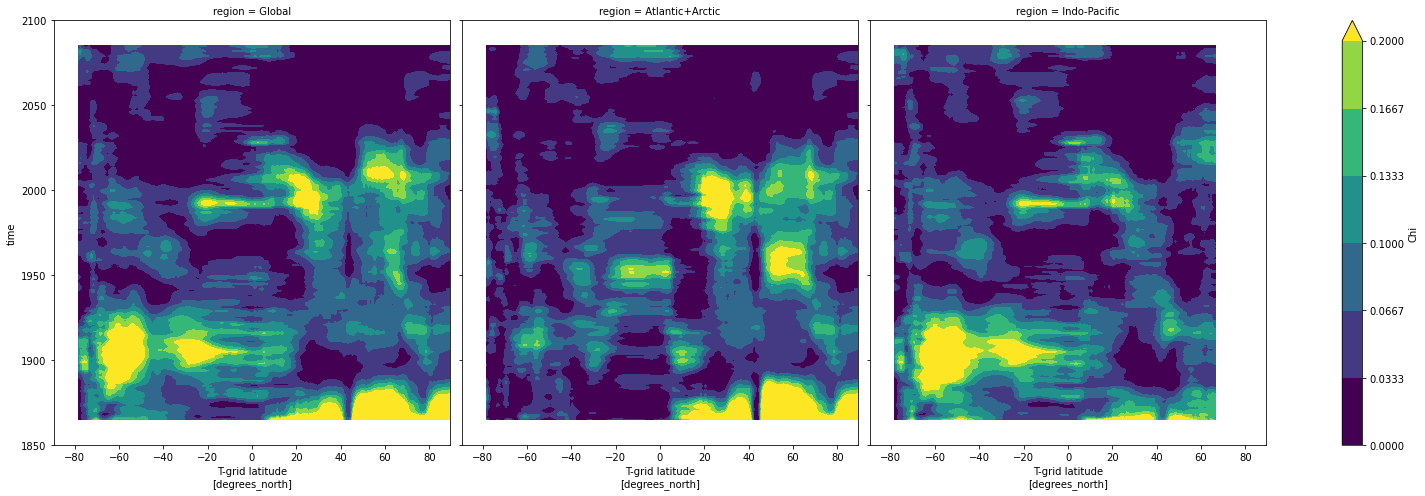

In [17]:
#fig, axes = plt.subplots(ncols=3)
chi_ocn.plot.contourf(col='region',vmin=0,vmax=0.2,size=7)
#chi_ocn_lpf.plot.contour(col='region',levels=[0.075],size=7,colors='r')

## Compute bootstrapped significance

In [14]:
import xskillscore as xs

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [15]:
%%time
iterations = 100
ens_size = 20
da_micros_r = xs.resample_iterations_idx(da_micros, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()

CPU times: user 4.45 s, sys: 2.34 s, total: 6.78 s
Wall time: 7.12 s


Now, resample again to generate 500 different 4-micro combinations:

In [16]:
da_micros_rr = xs.resample_iterations(da_micros_r, 500, 'micro', dim_max=4)

Compute resampled distributions of sig2_atm, sig2_ocn, and chi_ocn:

In [17]:
%%time
sig2_atm_r = da_micros_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_micros_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_micros_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")

CPU times: user 9.25 s, sys: 3.44 s, total: 12.7 s
Wall time: 31.2 s


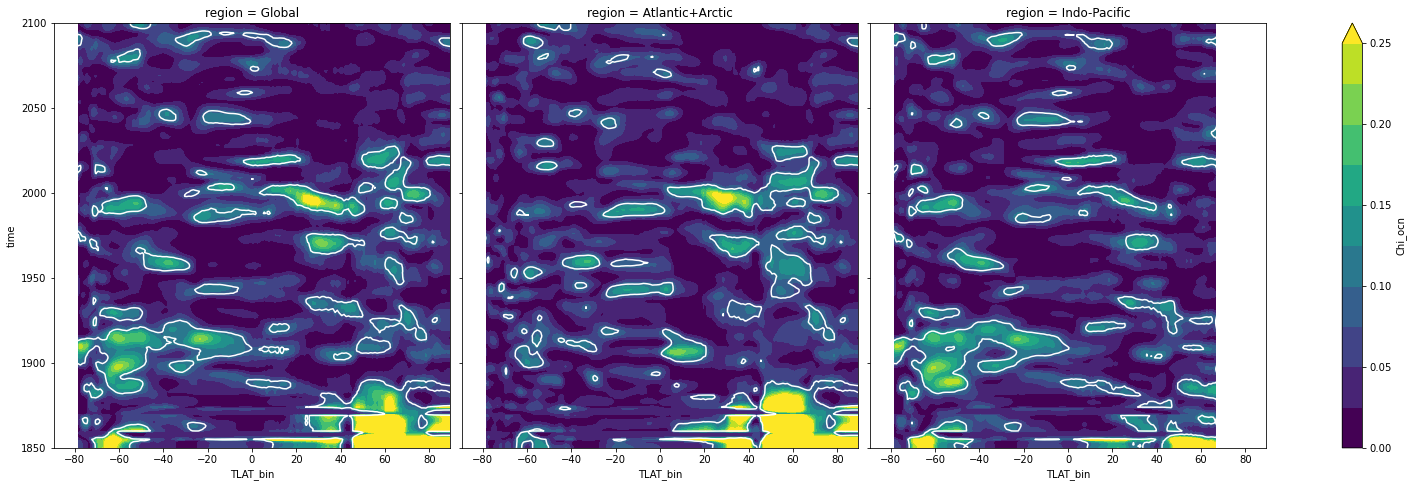

In [18]:
# Plot with bootstrapped significance
pval = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size
clevs = np.arange(0,11)*0.025

g = chi_ocn.plot.contourf(col='region',size=7,levels=clevs,cmap='viridis')
for i, ax in enumerate(g.axes.flat):
    pval.isel(region=i).plot.contour(ax=ax,levels=[0.05],colors=['white'])
    if (i>0): ax.set_ylabel('')

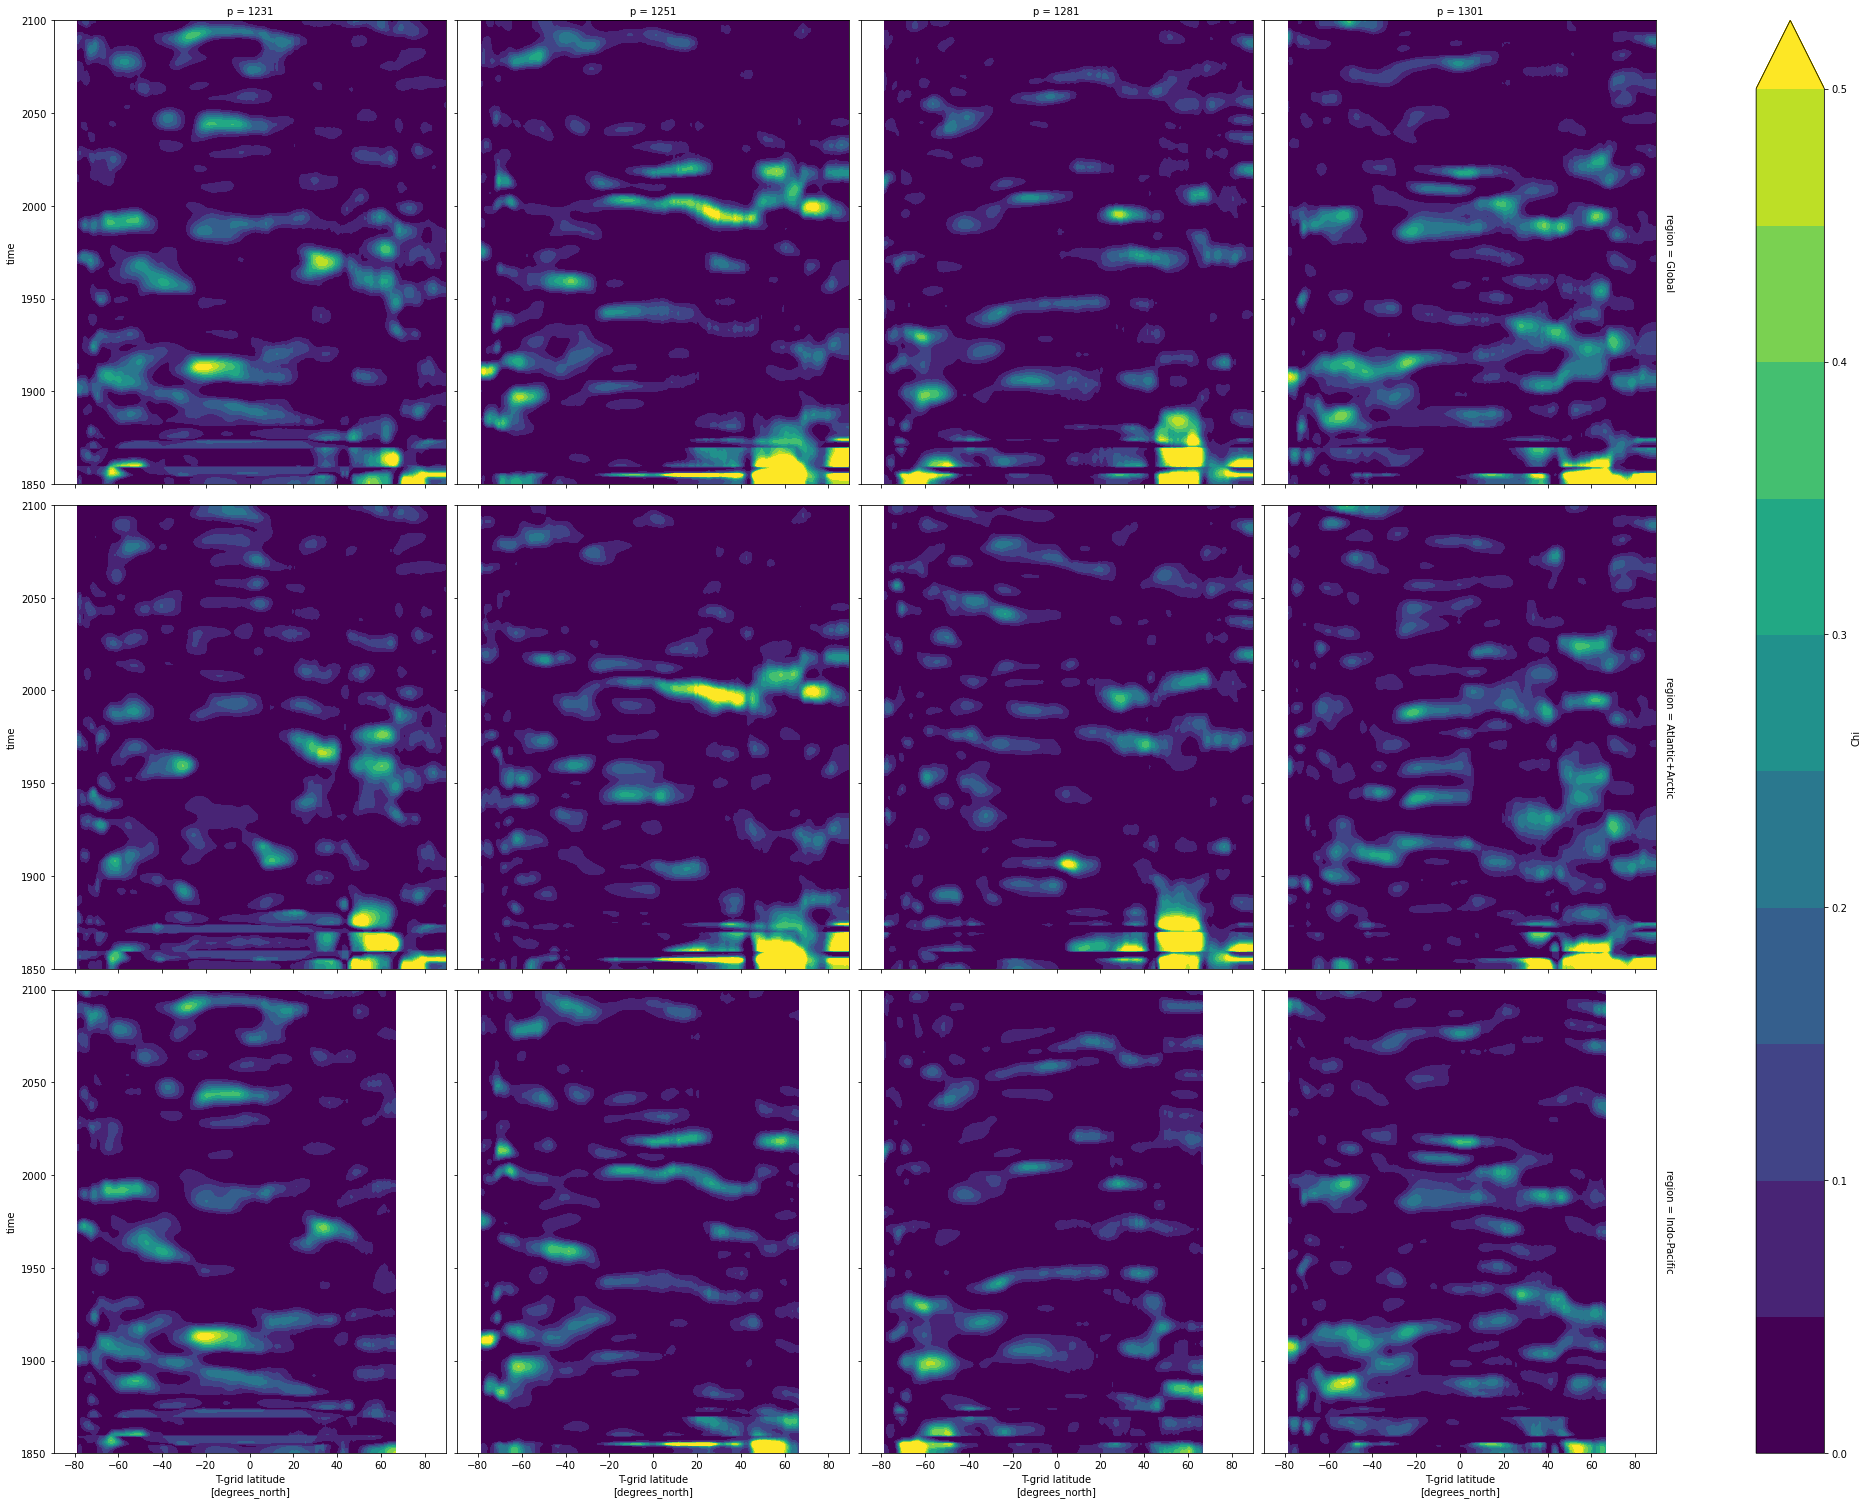

In [13]:
# Plot decomposition of Chi_ocn by init year:
levs = np.arange(0,11)*0.05
chi_ocn_p.plot.contourf(col='p',row='region',size=7,levels=levs)